In [1]:
from diffusers import DiffusionPipeline
import torch


model_id = "yahoo-inc/photo-background-generation"
pipeline = DiffusionPipeline.from_pretrained(model_id, custom_pipeline=model_id)
device = torch.device("cuda:0")


pipeline = pipeline.to(device)


/home/jupyter-kazancev.danil7@wb-2ede4/anaconda3/envs/anti_spam/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [2]:
# !pip install transparent_background

In [3]:
from PIL import Image, ImageOps
import requests
from io import BytesIO
from transparent_background import Remover

def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

seed = 0
orig_img = Image.open("test_imgs/village_sofa.webp")

resized_img = resize_with_padding(orig_img, (512, 512))

# Load background detection model
remover = Remover(mode='fast', device='cuda:0', ckpt='weights/ckpt_fast.pth') # default setting
# remover = Remover(mode='base') # nightly release checkpoint

# Get foreground mask
fg_mask = remover.process(resized_img, type='map') # default setting - transparent background


/home/jupyter-kazancev.danil7@wb-2ede4/anaconda3/envs/anti_spam/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Settings -> Mode=fast, Device=cuda:0, Torchscript=disabled


In [4]:
from lib.clip_classifier import ClipClassfifier
import json

with open('data.json', 'r') as f:
    data = json.load(f)
    
clip_clf = ClipClassfifier(data["furniture_types"])


2024-06-11 15:01:21.029 | INFO     | lib.clip_classifier:describe_image:27 - Provided item classified as sofa which must placed outdoor


Description: {'furniture': 'sofa', 'category': 'outdoor'}


In [12]:
item_description = clip_clf.describe_image(orig_img)
print(f"Description: {description}")

prompt_structure = f"A {furniture_name} on {location}"

2024-06-11 15:03:02.147 | INFO     | lib.clip_classifier:describe_image:27 - Provided item classified as sofa which must placed outdoor


Description: {'furniture': 'sofa', 'category': 'outdoor'}


In [13]:
data

{'furniture_types': ['chair',
  'table',
  'sofa',
  'bed',
  'lamp',
  'chandelier',
  'garden table',
  'lounge chair',
  'beach umbrella',
  'swimming pool',
  'beach lounger',
  'garden swing',
  'hammock',
  'hanging chair',
  'gazebo'],
 'indoor': [],
 'outdoor': ['village house nearby with grass']}

  0%|          | 0/20 [00:00<?, ?it/s]

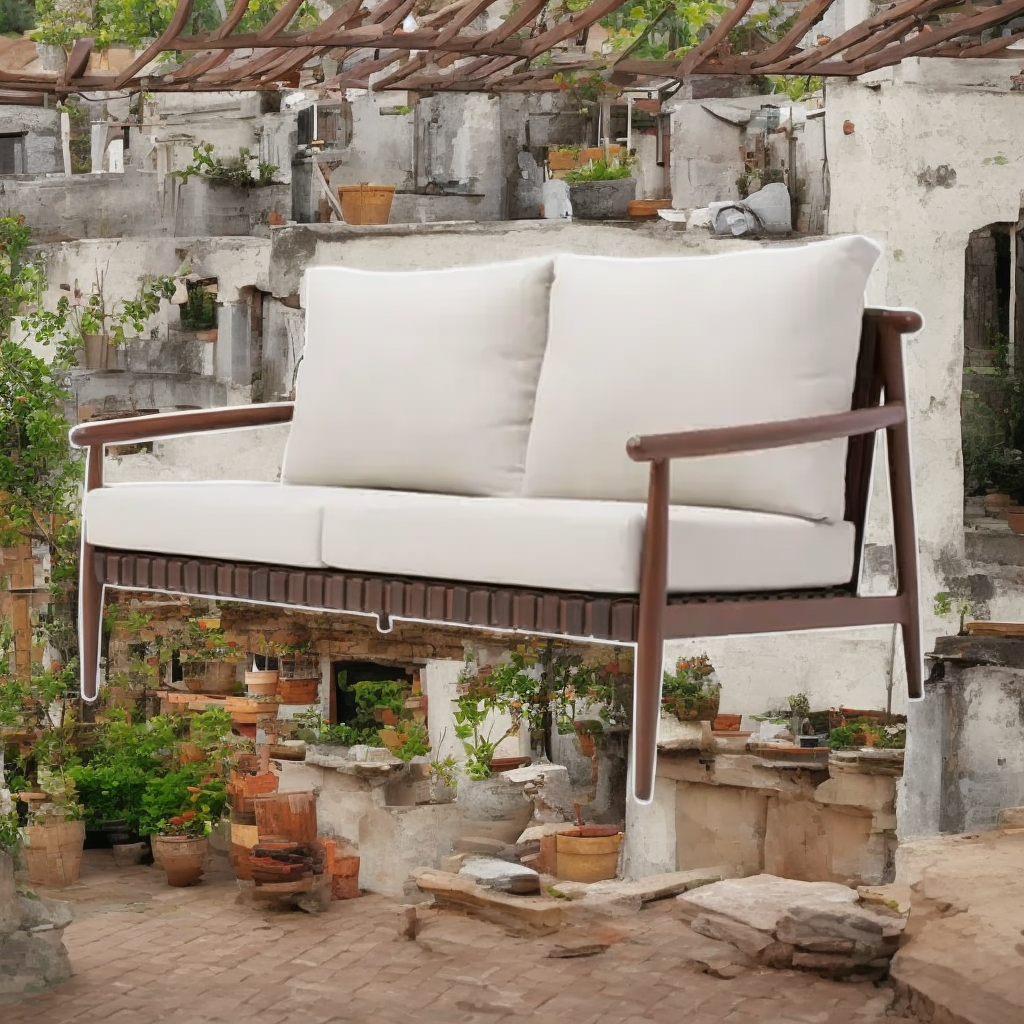

In [19]:
seed = 10
cond_scale = 1.0
mask = ImageOps.invert(fg_mask)

generator = torch.Generator(device='cuda').manual_seed(seed)

prompt = f"A {item_description['furniture']} on a house wood village terrace"

with torch.autocast('cuda'):
    controlnet_image = pipeline(
        prompt=prompt, 
        height = 1024,
        width=1024,
        image=resized_img, mask_image=mask,
        control_image=mask, num_images_per_prompt=1,
        generator=generator, num_inference_steps=20,
        guess_mode=False,
        controlnet_conditioning_scale=cond_scale
    ).images[0]

controlnet_image


In [ ]:
fg_mask

In [ ]:
import torch
from PIL import Image
import numpy as np
from RealESRGAN import RealESRGAN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RealESRGAN(device, scale=4)
model.load_weights('weights/RealESRGAN_x4.pth', download=True)


sr_image = model.predict(controlnet_image)

# sr_image.save('results/sr_image.png')


In [ ]:
sr_image